In [25]:
from utils.scenario_gen import *
from utils.trees import *
from utils.clustering import *
from utils.optimization import *

from pathlib import Path
import pickle
from pyomo.util.infeasible import log_infeasible_constraints
import logging

In [43]:
class ClosedLoopSimulation():
    """
    Class for closed-loop simulation of the DR optimization problem.
    """
    def __init__(self, savepath, simulation_index, optimization_settings, observation_dataclass, scenario_dataclass, idm_scenarioclass, tree_classes=['discharge', 'wl'], simulation_data=None, save_individual_timesteps=False):
        self.obs = observation_dataclass
        self.scenario = scenario_dataclass
        self.idm_scenario = idm_scenarioclass
        self.control_horizon = 48 # hour
        self.simulation_index = simulation_index
        self.idx = pd.IndexSlice
        self.optimization_settings = optimization_settings
        self.savepath = savepath
        self.save_individual_timesteps = save_individual_timesteps
        self.refit_idm_bn_every = self.optimization_settings['refit_idm_bn_every']

        self.savepath.mkdir(exist_ok=True)
        if self.save_individual_timesteps:
            self.savepath_timesteps = self.savepath / 'timesteps'
            self.savepath_timesteps.mkdir(exist_ok=True)

        self.tree_shaped = tree_classes

        # Initialize simulation data
        # This will be the dataframe that contains the performed actions.
        if simulation_data is None: # Start from scratch
            self.simulation_data = pd.DataFrame(
                index=self.simulation_index,
                columns=['h_nzk', 'Q_gate', 'Q_pump', 'Q_wb', 'Q_ark', 'E_act', 'E_dam', 'h_ns', 'p_dam', 'p_idm']
            )
            
            # Start with a half full reservoir
            self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), 'h_nzk'] = self.optimization_settings['start_wl']
            self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), [col for col in self.simulation_data.columns if col != 'h_nzk']] = 0
            self.simulation_data = self.simulation_data.sort_index()

            # Start with initial DAM bid of 0
            startdate = self.simulation_index.min()
            idm_index = pd.date_range(startdate, startdate + pd.DateOffset(hours=23-startdate.hour), freq='H')
            self.simulation_data.loc[idm_index, 'E_dam'] = 0

        else:
            self.simulation_data = simulation_data


    def _get_idm_scenarios(self, t_now):
        # Get the current DAM prices (observed) untill the next DAM price
        dam_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), freq='H', periods=25) # 25 because we need the DAM price of the hour before this day as well
        dam_obs = self.obs.get_observation_data_single('DAM', dam_obs_index[0], dam_obs_index[-1])

        # Get the IDM scenarios untill now (observed)
        idm_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), t_now - pd.DateOffset(hours=1), freq='H')
        idm_obs = self.obs.get_observation_data_single('IDM', idm_obs_index[0], idm_obs_index[-1])
        
        if self.idm_scenario.method != 'obs':
            # Get the IDM scenarios untill the DAM (forecast / generated)
            return self.idm_scenario(dam_obs.values.flatten(), idm_obs.values.flatten(), 10)
        else:
            # If observations -> return the observation data
            idm_scen_index = pd.date_range(idm_obs_index[-1]+pd.DateOffset(hours=1), freq='H', periods=len(dam_obs_index)-len(idm_obs_index))
            return self.obs.get_observation_data_single('IDM', idm_scen_index[0], idm_scen_index[-1]).values.flatten()


    def prep_opt_data(self, t_now, inplace=True, return_data=False):
        """
        Prepare the optimization data for the optimization problem.
        This will return the data that is used to calculate the optimal actions.
        So we return:
        - the observation at t_now
        - the IDM scenarios untill the DAM
        - the DAM scenarios
        """

        # Get the observations of the external variables at t_now-1h (so one timestep )
        t_prev = t_now - pd.DateOffset(hours=1)
        dam_o, idm_o, wl_hourly_o, discharge_o, ark_o = self.obs.get_observation_data(start=t_prev, end=t_now)

        # Get the observations of the discharge at ark, this is a perfect forecast.
        ark_meas = self.obs.get_observation_data_single(var='ARK', start=t_now, end=t_now+pd.DateOffset(hours=self.control_horizon))
        
        # Get the observations of h_nzk at t_now-1h (so one timestep )
        # We need to get the h_nzk at t_now-1h, because we need to know the state of the system to decide control actions
        # So we decide the control action from t_now:t_now+control_horizon
        h_nzk_o = self.simulation_data.loc[t_prev, 'h_nzk']

        # Get the IDM scenarios untill the DAM
        idm_scenarios = self._get_idm_scenarios(t_now).astype(float)
        if len(idm_scenarios.shape) == 1:
            idm_scenarios_df = pd.DataFrame(index=[0], columns=range(1, idm_scenarios.shape[0]+2), dtype=float)
            idm_scenarios_df.iloc[:, :-1] = idm_scenarios
            idm_scenarios_df.iloc[:, -1] = 1
            idm_scenarios_df.columns = [i for i in range(1, idm_scenarios.shape[0]+1)] + ['weights']
            idm_scenarios = idm_scenarios_df

        # print(idm_scenarios.shape)

        # print(self.scenario.wl.index)
        # Get the DAM scenarios for tomorrow -> DA bid and prep
        next_dam_timestep = t_now + pd.DateOffset(hours=24-t_now.hour)
        dam_scenarios = self.scenario.get_scenarios(next_dam_timestep, 'DAM').copy()
        # Select the DAM scenarios untill t_now+48h
        dam_weights = dam_scenarios.iloc[:, [-1]].copy()
        dam_scenarios = pd.concat([dam_scenarios.iloc[:, [i for i in range(self.control_horizon - (idm_scenarios.shape[1] - 1))]], dam_weights], axis=1).astype(float)

        # Get the WL scenarios for the next 48 hours
        wl_scenarios = self.scenario.get_scenarios(t_now, 'wl').copy()
        wl_scenarios.iloc[:, :-1] = wl_scenarios.iloc[:, :-1] / 100 # cm+NAP to m+NAP

        # Get the discharge scenarios for the next 48 hours
        discharge_scenarios = self.scenario.get_scenarios(t_now, 'discharge').copy()

        optimization_data = {}
        optimization_data['dam'] = {}
        optimization_data['idm'] = {}
        optimization_data['wl'] = {}
        optimization_data['wb_discharge'] = {}
        optimization_data['h_nzk'] = {}
        optimization_data['ark_discharge'] = {}
        optimization_data['probabilities'] = {}
        optimization_data['E_dam'] = {}
        
        optimization_data['h_nzk'][-1] = h_nzk_o # Both are the last calculated, so t-1h!
        optimization_data['h_nzk'][0] = h_nzk_o

        optimization_data['dam'][-1] = dam_o.values[0].round(2)
        optimization_data['dam'][0] = dam_o.values[1].round(2)
        optimization_data['idm'][-1] = idm_o.values[0].round(2)
        optimization_data['idm'][0] = idm_o.values[1].round(2)
        optimization_data['wl'][-1] = wl_hourly_o.values[0].round(3)[0]
        optimization_data['wl'][0] = wl_hourly_o.values[1].round(3)[0]
        
        optimization_data['wb_discharge'][-1] = discharge_o.values[0].round(2)
        optimization_data['wb_discharge'][0] = discharge_o.values[1].round(2)
        optimization_data['ark_discharge'][-1] = ark_o.values[0].round(2)
        optimization_data['ark_discharge'][0] = ark_o.values[1].round(2)

        n_id_timesteps = len(idm_scenarios.columns) - 1 # -1 since weights are in DF
        # Intraday trading
        for t_id in range(1,  n_id_timesteps+1): 
            optimization_data['dam'][t_id] = np.nan
            optimization_data['idm'][t_id] = idm_scenarios.iloc[:, t_id-1].values.round(2)
            optimization_data['ark_discharge'][t_id] = ark_meas.iloc[t_id-1].values.round(2)
            if 'discharge' not in self.tree_shaped:
                optimization_data['wb_discharge'][t_id] = discharge_scenarios.iloc[:, t_id-1].values.round(2)
            if 'wl' not in self.tree_shaped:
                optimization_data['wl'][t_id] = wl_scenarios.iloc[:, t_id-1].values.round(3)

            # Get the DAM bid made for the ID trading period
            optimization_data['E_dam'][t_id] = self.simulation_data.loc[t_now + pd.DateOffset(hours=t_id-1), 'E_dam']

        # DA trading
        for t in range(n_id_timesteps+1, self.control_horizon+1):
            optimization_data['dam'][t] = dam_scenarios.iloc[:, t-n_id_timesteps-1].values.round(2)
            optimization_data['idm'][t] = np.nan # NO multistage IDM yet
            optimization_data['ark_discharge'][t] = ark_meas.iloc[t-1].values.round(2)
            if 'discharge' not in self.tree_shaped:
                optimization_data['wb_discharge'][t] = discharge_scenarios.iloc[:, t-1].values.round(2)
            if 'wl' not in self.tree_shaped:
                optimization_data['wl'][t] = wl_scenarios.iloc[:, t-1].values.round(2)
            optimization_data['E_dam'][t] = np.nan
        
        optimization_data['probabilities']['dam'] = dam_scenarios.iloc[:, -1].values.round(3)
        optimization_data['probabilities']['idm'] = idm_scenarios.iloc[:, -1].values.round(3)

        if 'discharge' in self.tree_shaped:
            optimization_data['wb_discharge'][1] = self.scenario.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)
        else:
            optimization_data['probabilities']['wb_discharge'] = discharge_scenarios.iloc[:, -1].values.round(3)
        
        if 'wl' in self.tree_shaped:
            optimization_data['wl'][1] = self.scenario.generate_tree(t_now, 'wl', scenarios=wl_scenarios)
        else:
            optimization_data['probabilities']['wl'] = wl_scenarios.iloc[:, -1].values.round(3)

        if inplace:
            self.optimization_data = optimization_data
        if return_data:
            return optimization_data
    
    def optimize(self, t_now):
        """
        Optimize the control actions for the next 48 hours.
        """
        # if ('wl' in self.tree_shaped) and ('discharge' in self.tree_shaped):
        self.prep_opt_data(t_now, inplace=True, return_data=False)
        logfile = str((self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.log').resolve())
        problem = NZKProblem(
            optimization_data=self.optimization_data,
            optimization_settings=self.optimization_settings,
            pred_hor=self.control_horizon,
            tree_classes=self.tree_shaped,
            logfile=logfile
        )
        problem.make_model()
        model = problem.solve(verbose=False)
        results = problem.get_results(model)

        if self.save_individual_timesteps:
            with open(self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.pkl', 'wb') as f:
                pickle.dump(results, f)

        return results
        # else:
        #     raise NotImplementedError('Only implemented for tree shaped variables')
    
    def _correct_q_gate(self, q, dh):
        N=7 # kokers
        B=5.9 # m
        a=1.0 # coefficient
        H=4.8 #m keelhoogte
        g=9.81 # m/s^2
        q_max = N*a*B*H* np.sqrt(2*g*dh)
        return np.round(min(q, q_max), decimals=2)
    
    def _correct_q_pump(self, q, dh):
        a = -3.976
        b = -17.7244
        c = 269.58
        q_max = a*dh**2 + b*dh + c
        return np.round(min(q, q_max), decimals=2)

    def pump_energy(self, q, dh, dt=3600):
        return (0.033*q**2 + 0.061*dh**2*q + 11.306*dh*q) * dt / 3600 / 1000 # MWh
    
    def calculate_expected_energy(self, timestep_index, results, dt=3600):
        """
        Calculate the expected energy use over all scenarios.
        Timestep index is the index of optimization timestep (so [1,48])
        """
        E_exp = 0
        for node in results:
            if timestep_index in node.domain:
                node_timestep_index = node.domain.index(timestep_index)
                q_pump = node.results['q_pump'][node_timestep_index]
                h_nzk = node.results['h_nzk'][node_timestep_index]

                wl_node_timestep_index = node.wl_node.domain.index(timestep_index)
                wl_ns = node.wl_node.values[wl_node_timestep_index]
                
                dh = max(wl_ns - h_nzk, 0)
                q_pump = self._correct_q_pump(q_pump, dh)
                E_exp += node.p_marginal * self.pump_energy(q_pump, dh, dt)
        return E_exp

    def simulate_timestep(self, t_now, results):
        """
        Simulate the next timestep.
        """
        # Get the observations of the external variables at t_now-1h (so one timestep)
        wl_ns = np.round(self.optimization_data['wl'][0], decimals=3) # accuracy in mm
        h_nzk0 = self.optimization_data['h_nzk'][0] # accuracy in mm
        q_wb = np.round(self.optimization_data['wb_discharge'][0], decimals=2)[0]
        q_ark = np.round(self.optimization_data['ark_discharge'][0], decimals=2)[0]
        dh_gate = max(h_nzk0 - wl_ns, 0)
        dh_pump = max(wl_ns - h_nzk0, 0)

        # Get the actions (Q_gate, Q_pump) from the optimization results, correct them for the physical limitations.
        q_gate = self._correct_q_gate(results[0].results['q_gate'][0], dh_gate)
        q_pump = self._correct_q_pump(results[0].results['q_pump'][0], dh_pump)
        
        # Calculate the next water level
        A_nzk = 36*10e6 # m^2
        dt = 3600 # s
        q_out = q_gate + q_pump
        q_in = q_wb + q_ark
        h_nzk1 = np.round(h_nzk0 + (q_in - q_out) * dt / A_nzk, decimals=4)
        E_act = self.pump_energy(q_pump, dh_pump, dt) # MWh

        self.simulation_data.loc[t_now, 'h_nzk'] = h_nzk1
        self.simulation_data.loc[t_now, 'Q_gate'] = q_gate
        self.simulation_data.loc[t_now, 'Q_pump'] = q_pump
        self.simulation_data.loc[t_now, 'Q_wb'] = q_wb
        self.simulation_data.loc[t_now, 'Q_ark'] = q_ark
        self.simulation_data.loc[t_now, 'E_act'] = E_act
        self.simulation_data.loc[t_now, 'h_ns'] = wl_ns
        self.simulation_data.loc[t_now, 'p_dam'] = self.optimization_data['dam'][0].flatten()[0]
        self.simulation_data.loc[t_now, 'p_idm'] = self.optimization_data['idm'][0].flatten()[0]

        if t_now.hour == 11:
            # Make a DAM bid at 11:00 AM for the next day (00:00 - 24:00)
            # We bid the expected energy use over all scenarios
            dam_start = 24 - t_now.hour 
            for t in range(dam_start, dam_start + 24):
                self.simulation_data.loc[t_now + pd.DateOffset(hours=t), 'E_dam'] = self.calculate_expected_energy(t+1, results, dt) # +1 because time starts at 1 in the optimization problem
    
    def check_refit_bn(self, t_now):
        if self.optimization_settings['distance'] != 'obs':
            if t_now - self.idm_scenario.t_max > pd.Timedelta(value=self.refit_idm_bn_every, unit='hours'):
                print('Refitting IDM BN')
                self.idm_scenario.update_bn(t_min=t_now-pd.DateOffset(days=365), t_max=t_now)

    def run_simulation(self, save_every=1):
        t0 = self.simulation_data.loc[self.simulation_data.isna().any(axis=1)].index.min()
        print('Running simulation from', t0)
        
        i=0
        while self.simulation_data.index[1] + pd.DateOffset(hours=i*self.refit_idm_bn_every) < t0:
            i += 1
        t_refit = self.simulation_data.index[1] + pd.DateOffset(hours=(i-1)*self.refit_idm_bn_every)
        self.check_refit_bn(t_refit)
        
        for i, date in enumerate(tqdm(self.simulation_data.loc[t0:].index)):
            if i % save_every == 0:
                # self.simulation_data.to_csv(self.savepath / 'simulation_data.csv')
                self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')
            results = self.optimize(date)
            self.simulate_timestep(date, results)
            self.check_refit_bn(date)
        self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')

In [44]:
datapath = Path(Path().resolve()).parent.parent.parent / 'data'
scenario_path = Path(Path().resolve()).parent.parent.parent / 'data' / 'forecast data' / 'Scenarios'
market_datapath = datapath / 'market data'
wl_datapath = datapath / 'waterlevel data'
wb_datapath = datapath / 'waterboard data'
ark_datapath = datapath / 'ark data'

optimization_datapath = datapath / 'optimization data'

In [45]:
n_scenarios = 1
method='obs'
if n_scenarios <= 3:
    n_wb_scenarios=3
scenario_params = {
    'DAM': {
        'n': n_scenarios,
        'method': method
    },
    'IDM':{
        'n_init': 100,
        'n': n_scenarios,
        'method': method,
    },
    'wl': {
        'n': n_scenarios,
        'method': method
    },
    'discharge': {
        'n': n_scenarios,
        'n_wb': n_wb_scenarios,
        'method': method
    },
    'n_root_steps': 3
}

In [28]:
obs_data = ObservationData(market_datapath, wl_datapath, wb_datapath, ark_datapath)

In [29]:
idm_scenarios = IDMScenarios(
    obs_dataclass=obs_data,
    n_init=100,
    n=n_scenarios,
    method=method,
    cluster=True,
)
t_min = idm_scenarios.dam.index.min()
idm_scenarios.update_bn(t_min=t_min, t_max=t_min + pd.DateOffset(days=365))

In [30]:
idm_scenarios.dam.index.min()

Timestamp('2018-01-01 00:00:00+0100', tz='Europe/Amsterdam')

In [31]:
scenario_data = ScenarioData(
    scenario_params=scenario_params,
    scenario_path=scenario_path,
    constrain_tree_complexity=True,
    complexity_reduction=0.5,
)

In [32]:
t_now = obs_data.dam.index[11] + pd.DateOffset(years=1, days=0) # Misschien in maart beginnen? Of iig deels? Die was vrij nat.
simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(days=30, hours=12), freq='H')
simulation_index

DatetimeIndex(['2019-01-01 11:00:00+01:00', '2019-01-01 12:00:00+01:00',
               '2019-01-01 13:00:00+01:00', '2019-01-01 14:00:00+01:00',
               '2019-01-01 15:00:00+01:00', '2019-01-01 16:00:00+01:00',
               '2019-01-01 17:00:00+01:00', '2019-01-01 18:00:00+01:00',
               '2019-01-01 19:00:00+01:00', '2019-01-01 20:00:00+01:00',
               ...
               '2019-01-31 14:00:00+01:00', '2019-01-31 15:00:00+01:00',
               '2019-01-31 16:00:00+01:00', '2019-01-31 17:00:00+01:00',
               '2019-01-31 18:00:00+01:00', '2019-01-31 19:00:00+01:00',
               '2019-01-31 20:00:00+01:00', '2019-01-31 21:00:00+01:00',
               '2019-01-31 22:00:00+01:00', '2019-01-31 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=733, freq='H')

In [33]:
# class ClosedLoopSimulation():
#     """
#     Class for closed-loop simulation of the DR optimization problem.
#     """
#     def __init__(self, savepath, simulation_index, optimization_settings, observation_dataclass, scenario_dataclass, idm_scenarioclass, tree_classes=['discharge', 'wl'], simulation_data=None, save_individual_timesteps=False):
#         self.obs = observation_dataclass
#         self.scenario = scenario_dataclass
#         self.idm_scenario = idm_scenarioclass
#         self.control_horizon = 48 # hour
#         self.simulation_index = simulation_index
#         self.idx = pd.IndexSlice
#         self.optimization_settings = optimization_settings
#         self.savepath = savepath
#         self.save_individual_timesteps = save_individual_timesteps
#         self.refit_idm_bn_every = self.optimization_settings['refit_idm_bn_every']

#         self.savepath.mkdir(exist_ok=True)
#         if self.save_individual_timesteps:
#             self.savepath_timesteps = self.savepath / 'timesteps'
#             self.savepath_timesteps.mkdir(exist_ok=True)

#         self.tree_shaped = tree_classes

#         # Initialize simulation data
#         # This will be the dataframe that contains the performed actions.
#         if simulation_data is None: # Start from scratch
#             self.simulation_data = pd.DataFrame(
#                 index=self.simulation_index,
#                 columns=['h_nzk', 'Q_gate', 'Q_pump', 'Q_wb', 'Q_ark', 'E_act', 'E_dam', 'h_ns', 'p_dam', 'p_idm']
#             )
            
#             # Start with a half full reservoir
#             self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), 'h_nzk'] = self.optimization_settings['start_wl']
#             self.simulation_data.loc[self.simulation_data.index[0]-pd.DateOffset(hours=1), [col for col in self.simulation_data.columns if col != 'h_nzk']] = 0
#             self.simulation_data = self.simulation_data.sort_index()

#             # Start with initial DAM bid of 0
#             startdate = self.simulation_index.min()
#             idm_index = pd.date_range(startdate, startdate + pd.DateOffset(hours=23-startdate.hour), freq='H')
#             self.simulation_data.loc[idm_index, 'E_dam'] = 0

#         else:
#             self.simulation_data = simulation_data


#     def _get_idm_scenarios(self, t_now):
#         # Get the current DAM prices (observed) untill the next DAM price
#         dam_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), freq='H', periods=25) # 25 because we need the DAM price of the hour before this day as well
#         dam_obs = self.obs.get_observation_data_single('DAM', dam_obs_index[0], dam_obs_index[-1])

#         # Get the IDM scenarios untill now (observed)
#         idm_obs_index = pd.date_range(t_now - pd.DateOffset(hours=t_now.hour + 1), t_now - pd.DateOffset(hours=1), freq='H')
#         idm_obs = self.obs.get_observation_data_single('IDM', idm_obs_index[0], idm_obs_index[-1])

#         # Get the IDM scenarios untill the DAM (forecast / generated)
#         return self.idm_scenario(dam_obs.values.flatten(), idm_obs.values.flatten(), 10)

#     def prep_opt_data(self, t_now, inplace=True, return_data=False):
#         """
#         Prepare the optimization data for the optimization problem.
#         This will return the data that is used to calculate the optimal actions.
#         So we return:
#         - the observation at t_now
#         - the IDM scenarios untill the DAM
#         - the DAM scenarios
#         """

#         # Get the observations of the external variables at t_now-1h (so one timestep )
#         t_prev = t_now - pd.DateOffset(hours=1)
#         dam_o, idm_o, wl_hourly_o, discharge_o, ark_o = self.obs.get_observation_data(start=t_prev, end=t_now)

#         # Get the observations of the discharge at ark, this is a perfect forecast.
#         ark_meas = self.obs.get_observation_data_single(var='ARK', start=t_now, end=t_now+pd.DateOffset(hours=self.control_horizon))
        
#         # Get the observations of h_nzk at t_now-1h (so one timestep )
#         # We need to get the h_nzk at t_now-1h, because we need to know the state of the system to decide control actions
#         # So we decide the control action from t_now:t_now+control_horizon
#         h_nzk_o = self.simulation_data.loc[t_prev, 'h_nzk']

#         # Get the IDM scenarios untill the DAM
#         idm_scenarios = self._get_idm_scenarios(t_now).astype(float)

#         # Get the DAM scenarios for tomorrow -> DA bid and prep
#         next_dam_timestep = t_now + pd.DateOffset(hours=24-t_now.hour)
#         dam_scenarios = self.scenario.get_scenarios(next_dam_timestep, 'DAM').copy()
#         # Select the DAM scenarios untill t_now+48h
#         dam_weights = dam_scenarios.iloc[:, [-1]].copy()
#         dam_scenarios = pd.concat([dam_scenarios.iloc[:, [i for i in range(self.control_horizon - (idm_scenarios.shape[1] - 1))]], dam_weights], axis=1).astype(float)

#         # Get the WL scenarios for the next 48 hours
#         wl_scenarios = self.scenario.get_scenarios(t_now, 'wl').copy()
#         wl_scenarios.iloc[:, :-1] = wl_scenarios.iloc[:, :-1] / 100 # cm+NAP to m+NAP

#         # Get the discharge scenarios for the next 48 hours
#         discharge_scenarios = self.scenario.get_scenarios(t_now, 'discharge').copy()

#         optimization_data = {}
#         optimization_data['dam'] = {}
#         optimization_data['idm'] = {}
#         optimization_data['wl'] = {}
#         optimization_data['wb_discharge'] = {}
#         optimization_data['h_nzk'] = {}
#         optimization_data['ark_discharge'] = {}
#         optimization_data['probabilities'] = {}
#         optimization_data['E_dam'] = {}
        
#         optimization_data['h_nzk'][-1] = h_nzk_o # Both are the last calculated, so t-1h!
#         optimization_data['h_nzk'][0] = h_nzk_o

#         optimization_data['dam'][-1] = dam_o.values[0].round(2)
#         optimization_data['dam'][0] = dam_o.values[1].round(2)
#         optimization_data['idm'][-1] = idm_o.values[0].round(2)
#         optimization_data['idm'][0] = idm_o.values[1].round(2)
#         optimization_data['wl'][-1] = wl_hourly_o.values[0].round(3)[0]
#         optimization_data['wl'][0] = wl_hourly_o.values[1].round(3)[0]
        
#         # DIT GAAT FOUT? DEBIET MOET OP T1, NIET T0!!!!!!
#         # Waterbalans gaat h1 = h0 + (q_in1 - q_uit1) * dt / A
#         # Bij debiet gaan dict[0] en dict[1] dus over dezelfde tijdstap! Maar 0 is de observatie, 1 is de eerste voorspelling
#         # Moet eigk ook voor WL -> even checken/fixen Ties
#         # DONE!
#         optimization_data['wb_discharge'][-1] = discharge_o.values[0].round(2)
#         optimization_data['wb_discharge'][0] = discharge_o.values[1].round(2)
#         optimization_data['ark_discharge'][-1] = ark_o.values[0].round(2)
#         optimization_data['ark_discharge'][0] = ark_o.values[1].round(2)

#         n_id_timesteps = len(idm_scenarios.columns) - 1 # -1 since weights are in DF
#         # Intraday trading
#         for t_id in range(1,  n_id_timesteps+1): 
#             optimization_data['dam'][t_id] = np.nan
#             optimization_data['idm'][t_id] = idm_scenarios.iloc[:, t_id-1].values.round(2)
#             optimization_data['ark_discharge'][t_id] = ark_meas.iloc[t_id-1].values.round(2)
#             if 'discharge' not in self.tree_shaped:
#                 optimization_data['wb_discharge'][t_id] = discharge_scenarios.iloc[:, t_id-1].values.round(2)
#             if 'wl' not in self.tree_shaped:
#                 optimization_data['wl'][t_id] = wl_scenarios.iloc[:, t_id-1].values.round(3)

#             # Get the DAM bid made for the ID trading period
#             optimization_data['E_dam'][t_id] = self.simulation_data.loc[t_now + pd.DateOffset(hours=t_id-1), 'E_dam']

#         # DA trading
#         for t in range(n_id_timesteps+1, self.control_horizon+1):
#             optimization_data['dam'][t] = dam_scenarios.iloc[:, t-n_id_timesteps-1].values.round(2)
#             optimization_data['idm'][t] = np.nan # NO multistage IDM yet
#             optimization_data['ark_discharge'][t] = ark_meas.iloc[t-1].values.round(2)
#             if 'discharge' not in self.tree_shaped:
#                 optimization_data['wb_discharge'][t] = discharge_scenarios.iloc[:, t-1].values.round(2)
#             if 'wl' not in self.tree_shaped:
#                 optimization_data['wl'][t] = wl_scenarios.iloc[:, t-1].values.round(2)
#             optimization_data['E_dam'][t] = np.nan
        
#         optimization_data['probabilities']['dam'] = dam_scenarios.iloc[:, -1].values.round(3)
#         optimization_data['probabilities']['idm'] = idm_scenarios.iloc[:, -1].values.round(3)

#         if 'discharge' in self.tree_shaped:
#             optimization_data['wb_discharge'][1] = self.scenario.generate_tree(t_now, 'discharge', scenarios=discharge_scenarios)
#         else:
#             optimization_data['probabilities']['wb_discharge'] = discharge_scenarios.iloc[:, -1].values.round(3)
        
#         if 'wl' in self.tree_shaped:
#             optimization_data['wl'][1] = self.scenario.generate_tree(t_now, 'wl', scenarios=wl_scenarios)
#         else:
#             optimization_data['probabilities']['wl'] = wl_scenarios.iloc[:, -1].values.round(3)

#         if inplace:
#             self.optimization_data = optimization_data
#         if return_data:
#             return optimization_data
    
#     def optimize(self, t_now):
#         """
#         Optimize the control actions for the next 48 hours.
#         """
#         if ('wl' in self.tree_shaped) and ('discharge' in self.tree_shaped):
#             self.prep_opt_data(t_now, inplace=True, return_data=False)
#             logfile = str((self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.log').resolve())
#             problem = NZKProblem(
#                 optimization_data=self.optimization_data,
#                 optimization_settings=self.optimization_settings,
#                 pred_hor=self.control_horizon,
#                 tree_classes=self.tree_shaped,
#                 logfile=logfile
#             )
#             problem.make_model()
#             model = problem.solve(verbose=False)
#             results = problem.get_results(model)

#             if self.save_individual_timesteps:
#                 with open(self.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d %H")}.pkl', 'wb') as f:
#                     pickle.dump(results, f)

#             return results
#         else:
#             raise NotImplementedError('Only implemented for tree shaped variables')
    
#     def _correct_q_gate(self, q, dh):
#         N=7 # kokers
#         B=5.9 # m
#         a=1.0 # coefficient
#         H=4.8 #m keelhoogte
#         g=9.81 # m/s^2
#         q_max = N*a*B*H* np.sqrt(2*g*dh)
#         return np.round(min(q, q_max), decimals=2)
    
#     def _correct_q_pump(self, q, dh):
#         a = -3.976
#         b = -17.7244
#         c = 269.58
#         q_max = a*dh**2 + b*dh + c
#         return np.round(min(q, q_max), decimals=2)

#     def pump_energy(self, q, dh, dt=3600):
#         return (0.033*q**2 + 0.061*dh**2*q + 11.306*dh*q) * dt / 3600 / 1000 # MWh
    
#     def calculate_expected_energy(self, timestep_index, results, dt=3600):
#         """
#         Calculate the expected energy use over all scenarios.
#         Timestep index is the index of optimization timestep (so [1,48])
#         """
#         E_exp = 0
#         for node in results:
#             if timestep_index in node.domain:
#                 node_timestep_index = node.domain.index(timestep_index)
#                 q_pump = node.results['q_pump'][node_timestep_index]
#                 h_nzk = node.results['h_nzk'][node_timestep_index]

#                 wl_node_timestep_index = node.wl_node.domain.index(timestep_index)
#                 wl_ns = node.wl_node.values[wl_node_timestep_index]
                
#                 dh = max(wl_ns - h_nzk, 0)
#                 q_pump = self._correct_q_pump(q_pump, dh)
#                 E_exp += node.p_marginal * self.pump_energy(q_pump, dh, dt)
#         return E_exp

#     def simulate_timestep(self, t_now, results):
#         """
#         Simulate the next timestep.
#         """
#         # Get the observations of the external variables at t_now-1h (so one timestep)
#         wl_ns = np.round(self.optimization_data['wl'][0], decimals=3) # accuracy in mm
#         h_nzk0 = self.optimization_data['h_nzk'][0] # accuracy in mm
#         q_wb = np.round(self.optimization_data['wb_discharge'][0], decimals=2)[0]
#         q_ark = np.round(self.optimization_data['ark_discharge'][0], decimals=2)[0]
#         dh_gate = max(h_nzk0 - wl_ns, 0)
#         dh_pump = max(wl_ns - h_nzk0, 0)

#         # Get the actions (Q_gate, Q_pump) from the optimization results, correct them for the physical limitations.
#         q_gate = self._correct_q_gate(results[0].results['q_gate'][0], dh_gate)
#         q_pump = self._correct_q_pump(results[0].results['q_pump'][0], dh_pump)
        
#         # Calculate the next water level
#         A_nzk = 36*10e6 # m^2
#         dt = 3600 # s
#         q_out = q_gate + q_pump
#         q_in = q_wb + q_ark
#         h_nzk1 = np.round(h_nzk0 + (q_in - q_out) * dt / A_nzk, decimals=4)
#         E_act = self.pump_energy(q_pump, dh_pump, dt) # MWh

#         self.simulation_data.loc[t_now, 'h_nzk'] = h_nzk1
#         self.simulation_data.loc[t_now, 'Q_gate'] = q_gate
#         self.simulation_data.loc[t_now, 'Q_pump'] = q_pump
#         self.simulation_data.loc[t_now, 'Q_wb'] = q_wb
#         self.simulation_data.loc[t_now, 'Q_ark'] = q_ark
#         self.simulation_data.loc[t_now, 'E_act'] = E_act
#         self.simulation_data.loc[t_now, 'h_ns'] = wl_ns
#         self.simulation_data.loc[t_now, 'p_dam'] = self.optimization_data['dam'][0].flatten()[0]
#         self.simulation_data.loc[t_now, 'p_idm'] = self.optimization_data['idm'][0].flatten()[0]

#         if t_now.hour == 11:
#             # Make a DAM bid at 11:00 AM for the next day (00:00 - 24:00)
#             # We bid the expected energy use over all scenarios
#             dam_start = 24 - t_now.hour 
#             for t in range(dam_start, dam_start + 24):
#                 self.simulation_data.loc[t_now + pd.DateOffset(hours=t), 'E_dam'] = self.calculate_expected_energy(t+1, results, dt) # +1 because time starts at 1 in the optimization problem
    
#     def check_refit_bn(self, t_now):
#         if t_now - self.idm_scenario.t_max > pd.Timedelta(value=self.refit_idm_bn_every, unit='hours'):
#             print('Refitting IDM BN')
#             self.idm_scenario.update_bn(t_min=t_now-pd.DateOffset(days=365), t_max=t_now)

#     def run_simulation(self, save_every=1):
#         t0 = self.simulation_data.loc[self.simulation_data.isna().any(axis=1)].index.min()
#         print('Running simulation from', t0)
        
#         i=0
#         while self.simulation_data.index[1] + pd.DateOffset(hours=i*self.refit_idm_bn_every) < t0:
#             i += 1
#         t_refit = self.simulation_data.index[1] + pd.DateOffset(hours=(i-1)*self.refit_idm_bn_every)
#         self.check_refit_bn(t_refit)
        
#         for i, date in enumerate(tqdm(self.simulation_data.loc[t0:].index)):
#             if i % save_every == 0:
#                 # self.simulation_data.to_csv(self.savepath / 'simulation_data.csv')
#                 self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')
#             results = self.optimize(date)
#             self.simulate_timestep(date, results)
#             self.check_refit_bn(date)
#         self.simulation_data.to_pickle(self.savepath / 'simulation_data.pkl')
            
            

In [47]:
optimization_settings = {
    'wl_constraint_type': 'robust',
    'var_wl': -0.4,
    'cvar_wl': -0.395,
    'cvar_alpha': 0.9,
    'p_chance': 0.1,
    'obj_type': 'expected_value',
    'refit_idm_bn_every': 7*24, # every week
    'start_wl': -0.4,
    'distance': 'energy',
    'n_scenarios': n_scenarios,
    'tree': False
}

In [48]:
def make_exp_name(optimization_settings):
    exp_name = optimization_settings['wl_constraint_type']
    if exp_name == 'cvar':
        exp_name += f'_{optimization_settings["cvar_alpha"]}'
        exp_name += f'_{abs(optimization_settings["cvar_wl"])}'
    elif exp_name == 'chance':
        exp_name += f'_{optimization_settings["p_chance"]}'
    elif exp_name == 'robust':
        pass
    else:
        raise NotImplementedError('Only implemented for cvar, chance and rosbut')
    exp_name += f'_{optimization_settings["distance"]}'
    exp_name += f'_{optimization_settings["n_scenarios"]}'
    if optimization_settings['tree']:
        exp_name += '_tree'
    else:
        exp_name += '_fan'
    return exp_name

In [49]:
exp_name = make_exp_name(optimization_settings)
exp_name

'robust_energy_1_fan'

In [50]:
# simulation_data = pd.read_pickle(optimization_datapath / exp_name / 'simulation_data.pkl')
simulation_data = None
# simulation_data = simulator.simulation_data.copy()
# simulation_data.dropna(how='all')

In [51]:
if optimization_settings['tree']:
    tree_classes = ['discharge', 'wl']
else:
    tree_classes = []

In [56]:
simulator = ClosedLoopSimulation(
    savepath=optimization_datapath / exp_name,
    optimization_settings=optimization_settings,
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
    save_individual_timesteps=True,
    simulation_data=simulation_data,
    tree_classes=tree_classes
)

In [53]:
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)

C:\Users\Heijden\AppData\Local\Temp\ipykernel_22652\3391168305.py:91: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  idm_scenarios_df.iloc[:, -1] = 1


In [ ]:
simulator.run_simulation(save_every=1)

In [ ]:
t_now = simulator.simulation_data.loc[simulator.simulation_data.isna().any(axis=1)].index.min()
t_now

Timestamp('2019-01-05 15:00:00+0100', tz='Europe/Amsterdam')

In [ ]:
t_now = t_now - pd.DateOffset(hours=16)
t_now

Timestamp('2019-01-04 23:00:00+0100', tz='Europe/Amsterdam')

In [ ]:
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)

In [ ]:
# data_dict

In [ ]:
# obs_data.wl_hourly.loc[t_now:t_now+pd.DateOffset(hours=47)]

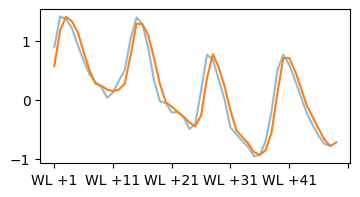

In [57]:
fig, ax = plt.subplots(figsize=(4,2))
wl_scenarios = simulator.scenario.get_scenarios(t_now, 'wl').copy()
(wl_scenarios.iloc[:,:-1].T / 100).plot(legend=False, alpha=0.5, ax=ax)
ax.plot(range(0,49), obs_data.wl_hourly.loc[t_now:t_now+pd.DateOffset(hours=48)])

In [58]:
data_dict['wl'][1].plot_tree()

AttributeError: 'numpy.ndarray' object has no attribute 'plot_tree'

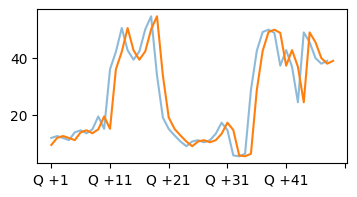

In [59]:
fig, ax = plt.subplots(figsize=(4,2))
wb_scenarios = simulator.scenario.get_scenarios(t_now, 'discharge').copy()
wb_scenarios.iloc[:,:-1].T.plot(legend=False, alpha=0.5, ax=ax)
ax.plot(range(0,49), obs_data.discharge.loc[t_now:t_now+pd.DateOffset(hours=48)])

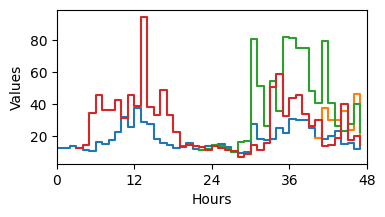

In [ ]:
data_dict['wb_discharge'][1].plot_tree()

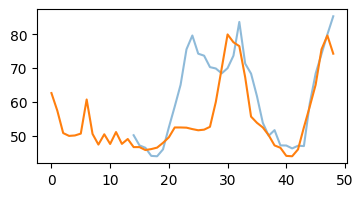

In [60]:
fig, ax = plt.subplots(figsize=(4,2))
dam_hours = [k for k in range(1, 49) if data_dict['dam'][k] is not np.nan]
dam_scenarios = pd.DataFrame(index=dam_hours, columns=range(len(data_dict['dam'][dam_hours[0]])))
for k in dam_hours:
    dam_scenarios.loc[k] = data_dict['dam'][k]
# dam_scenarios = data_dict['dam']
dam_scenarios.plot(legend=False, alpha=0.5, ax=ax)
ax.plot(range(0,49), obs_data.dam.loc[t_now:t_now+pd.DateOffset(hours=48)])

In [67]:
# print(data_dict['wl'][1].domain)
for node in data_dict['wl'][1][1][0]:
    print(node.domain)
    print(node.edge_values)
    print()

    

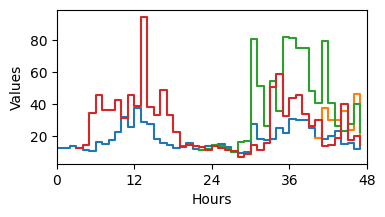

In [103]:
data_dict['wb_discharge'][1].plot_tree()

In [69]:
print([data_dict['ark_discharge'][k][0] for k in data_dict['ark_discharge'].keys()])

[10.42, 12.82, 12.82, 18.58, 26.94, 37.55, 31.16, 26.86, 25.06, 16.56, 17.24, 9.17, 10.52, 11.02, 11.46, 3.89, 3.41, -3.71, 3.49, 6.56, 6.38, 19.5, 18.65, 19.9, 29.33, 47.49, 40.54, 22.35, 8.88, -0.71, 5.35, 5.2, 1.35, 9.52, 11.66, 3.7, 5.29, 21.88, 31.49, 17.3, -3.45, -0.95, 1.22, 1.93, 12.05, 17.66, 17.19, 13.85, 27.18, 47.55]


In [70]:
print([data_dict['dam'][k].min() for k in data_dict['dam'].keys() if data_dict['dam'][k] is not np.nan])

[68.96, 64.12, 42.28, 39.88, 33.03, 34.56, 34.13, 37.24, 44.34, 37.33, 46.28, 56.1, 46.76, 43.74, 38.58, 36.54, 42.97, 39.14, 45.07, 55.88, 59.88, 50.97, 46.65, 44.26, 44.37, 37.38, 33.64, 31.49, 37.2, 35.44, 35.44, 28.6, 42.55, 43.6, 43.89, 46.61, 41.51, 46.97, 42.01, 40.9, 40.81]


In [71]:
print([data_dict['idm'][k].min() for k in data_dict['idm'].keys() if data_dict['idm'][k] is not np.nan])

[58.08, 57.61, 57.6, 55.27, 69.96, 64.84, 46.71, 54.69, 45.91, 40.15, 56.79]


In [61]:
print([data_dict['idm'][k] for k in data_dict['idm'].keys()])

[array([47.45]), array([55.55]), array([55.55]), array([94.29]), array([70.1]), array([67.96]), array([63.95]), array([57.44]), array([52.71]), array([57.19]), array([45.54]), array([43.69]), array([48.95]), array([43.86]), array([43.22]), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [72]:
# data_dict['wl'][1][0][0].edge_values

In [21]:
# data_dict['wl']
logfile = str((simulator.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d")}.log').resolve())

In [22]:
problem = NZKProblem(
    optimization_data=data_dict,
    optimization_settings=optimization_settings,
    tree_classes=tree_classes,
    pred_hor=48,
    logfile=logfile
)

In [23]:
problem.make_model()

In [24]:
model = problem.solve(verbose=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-04
Read LP format model from file C:\Users\Heijden\AppData\Local\Temp\tmp7ghq9mup.pyomo.lp
Reading time = 0.03 seconds
x7897: 7950 rows, 7897 columns, 19181 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Set parameter MIPGapAbs to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 7950 rows, 7897 columns and 19181 nonzeros
Model fingerprint: 0x61690683
Model has 3383 quadratic objective terms
Model has 5635 quadratic constraints
Variable types: 5641 continuous, 2256 integer (2256 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+01]
  QMatrix range    [1e-01, 2e+00]
  QLMatrix range   [1e-03, 3e+00]
  Objective range  [3e-05, 9e-01]
  QObjective range [8e-05, 1e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [2e-04, 1e+01]
  QRHS range

In [25]:
log_infeasible_constraints(model, log_expression=True, log_variables=True)
logging.basicConfig(filename='manual_run.log', encoding='utf-8', level=logging.INFO)

In [32]:
results = problem.get_results()

In [81]:
# simulator.optimization_data

In [82]:
simulator.simulate_timestep(t_now, results)

In [32]:
simulator.simulation_data

,h_nzk,Q_gate,Q_pump,Q_wb,Q_ark,E_act,E_dam,h_ns,p_dam,p_idm
2019-01-01 10:00:00+01:00,-0.4,0,0,0,0,0,0,0,0,0
2019-01-01 11:00:00+01:00,-0.3997,0.0,7.84,9.35,25.07,0.089085,0,0.577,62.62,55.55
2019-01-01 12:00:00+01:00,-0.3995,0.0,16.9,11.84,26.38,0.315194,0,1.187,57.4,94.29
2019-01-01 13:00:00+01:00,-0.3995,0.0,28.76,12.5,18.27,0.621418,0,1.41,50.76,70.1
2019-01-01 14:00:00+01:00,-0.3995,0.0,20.7,11.81,7.37,0.423394,0,1.333,49.92,67.96
...,...,...,...,...,...,...,...,...,...,...
2019-01-31 07:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 08:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 09:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 10:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
results[0].results

{'h_nzk': [-0.42555810000000005,
  -0.42491390000000007,
  -0.4243549000000001,
  -0.4238099000000001,
  -0.4232462000000001],
 'q_gate': [0.0, 0.0, 0.0, 0.0, 0.0],
 'q_pump': [0.0, 0.0, 0.0, 0.0, 0.0],
 'B_gate': [0.0, 0.0, 0.0, 0.0, 0.0],
 'B_pump': [1.0, 1.0, 1.0, 1.0, 1.0],
 'dH2': [2.3280656399999993,
  1.6865128606956103,
  1.473829749393209,
  0.9328756878540081,
  0.6562780500780083]}

In [63]:
results[10].p_marginal

0.04641

In [33]:
cb_colorlist = [
        '#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00'
    ]

In [34]:
def plot_nodesedges(ax, nodesedges, colorlist):
    for i, node in enumerate(nodesedges.nodes):
        domain = node.domain
        values = node.values

        parent_id = node.parent_id
        if parent_id is not None:
            parent = nodesedges.nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.values[-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post')
    

In [35]:
def plot_res(ax, var, result_nodes, colorlist):
    for i, node in enumerate(result_nodes):
        domain = node.domain
        values = node.results[var]

        parent_id = node.parent_id
        if parent_id is not None:
            parent = result_nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.results[var][-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post', linewidth=1)

In [36]:
def plot_results(results, problem, data_dict):
    fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
    # Inputs on the left
    plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
    ax[0,0].set_title('Discharge scenarios')
    ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

    plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
    ax[1,0].set_title('Water level scenarios')
    ax[1,0].set_ylabel('Water level [m+NAP]')


    # IDM prices
    idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
        ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

    # DAM prices
    dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
        ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

    ax[2,0].set_title('DAM and IDM prices')
    ax[2,0].set_ylabel('Price [€/MWh]')
    ax[2,0].set_xlabel('Time [h]')

    # Outputs on the right
    plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
    ax[0,1].set_title('Pump discharge')
    ax[0,1].set_ylabel('Pump discharge [m3/s]')

    plot_res(ax[1,1], 'q_gate', results, cb_colorlist)
    ax[1,1].set_title('Gate discharge')
    ax[1,1].set_ylabel('Gate discharge [m3/s]')

    plot_res(ax[2,1], 'h_nzk', results, cb_colorlist)
    ax[2,1].set_title('Water level')
    ax[2,1].set_ylabel('Water level [m+NAP]')
    # ax[2,1].set_ylim(-0.5, -0.35)
    ax[2,1].set_xlabel('Time [h]')

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    fig.tight_layout()
    return fig, ax
    

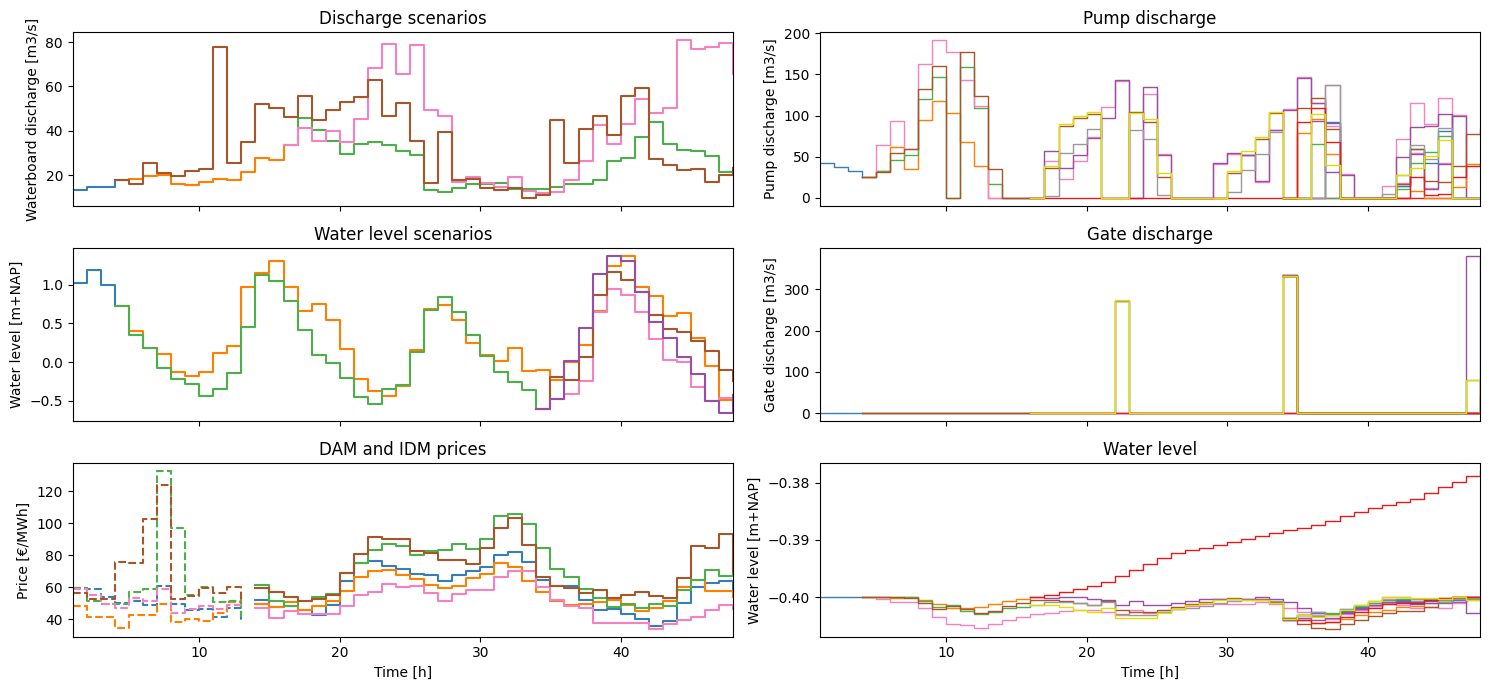

In [86]:
fig, ax = plot_results(results, problem, data_dict) # CVAR 0.9

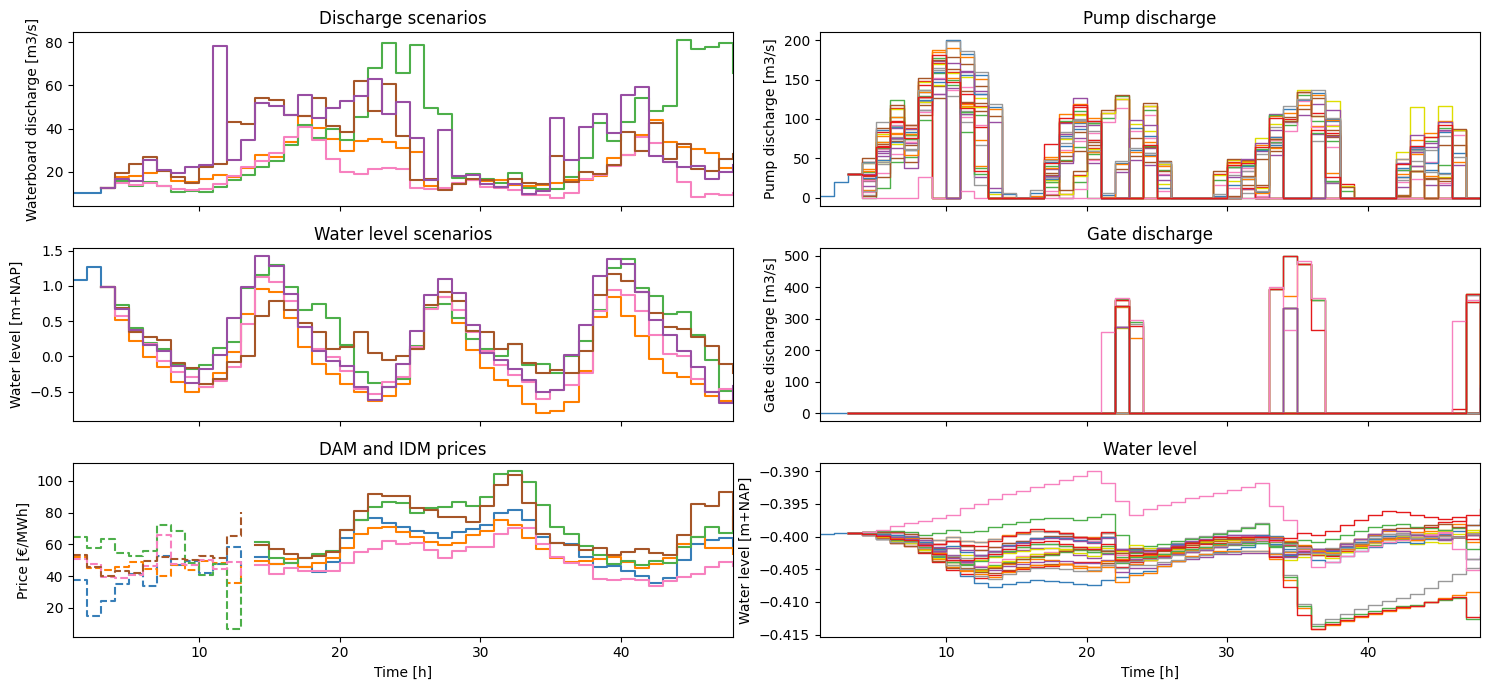

In [37]:
fig, ax = plot_results(results, problem, data_dict) # CVAR 0.8

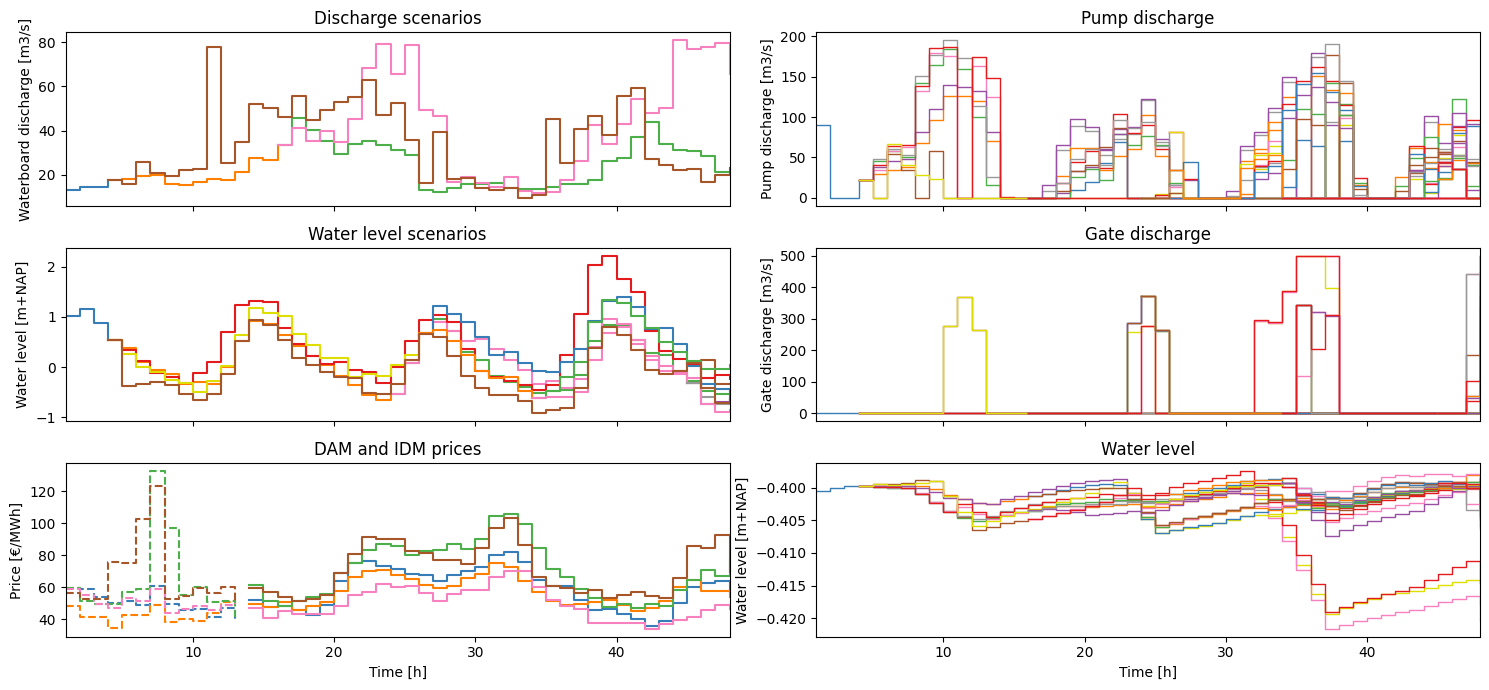

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
# Inputs on the left
plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
ax[0,0].set_title('Discharge scenarios')
ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
ax[1,0].set_title('Water level scenarios')
ax[1,0].set_ylabel('Water level [m+NAP]')


# IDM prices
idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
    ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

# DAM prices
dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
    ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

ax[2,0].set_title('DAM and IDM prices')
ax[2,0].set_ylabel('Price [€/MWh]')
ax[2,0].set_xlabel('Time [h]')

# Outputs on the right
plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
ax[0,1].set_title('Pump discharge')
ax[0,1].set_ylabel('Pump discharge [m3/s]')

plot_res(ax[1,1], 'q_gate', results, cb_colorlist)
ax[1,1].set_title('Gate discharge')
ax[1,1].set_ylabel('Gate discharge [m3/s]')

plot_res(ax[2,1], 'h_nzk', results, cb_colorlist)
ax[2,1].set_title('Water level')
ax[2,1].set_ylabel('Water level [m+NAP]')
# ax[2,1].set_ylim(-0.5, -0.35)
ax[2,1].set_xlabel('Time [h]')

for ax_ in ax.flatten():
    ax_.set_xlim(1,48)

fig.tight_layout()

In [89]:
optimization_settings

{'wl_constraint_type': 'cvar',
 'var_wl': -0.4,
 'cvar_wl': -0.395,
 'cvar_alpha': 0.8,
 'obj_type': 'expected_value',
 'refit_idm_bn_every': 168,
 'start_wl': -0.4,
 'distance': 'energy'}